In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models import *
from tqdm.notebook import tnrange, tqdm
from datetime import datetime

# Base Parameters

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preparation

In [3]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


# ResNet18

In [17]:
net = ResNet18()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
best_acc = 0

In [18]:
# Training
# tqdm Ref: https://adamoudad.github.io/posts/progress_bar_with_tqdm/
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    with tqdm(trainloader) as tepoch:
        tepoch.set_description(f"Training Epoch {epoch}")
        for batch_idx, (inputs, targets) in enumerate(tepoch):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            tepoch.set_postfix(loss= '{:.2f}'.format(train_loss / (batch_idx + 1)), acc='{:.2f}%'.format(100.*correct/total))
        return train_loss / (batch_idx + 1), 100.*correct/total

In [19]:
# Test
def test_res(epoch, save_name):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(testloader) as tepoch:
            tepoch.set_description(f"Testing Epoch {epoch}")
            for batch_idx, (inputs, targets) in enumerate(tepoch):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                tepoch.set_postfix(loss='{:.2f}'.format(test_loss / (batch_idx + 1)), acc='{:.2f}%'.format(100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + save_name + '.pth')
        best_acc = acc
    return test_loss / (batch_idx + 1), 100.*correct/total

In [21]:
# Execute Training
train_data = []
test_data = []
for epoch in tnrange(50, desc='Training and Testing Epochs'):
    train_d = train(epoch)
    train_data.append(train_d)
    test_d = test_res(epoch, 'resnet18')
    test_data.append(test_d)
    scheduler.step()

Training and Testing Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

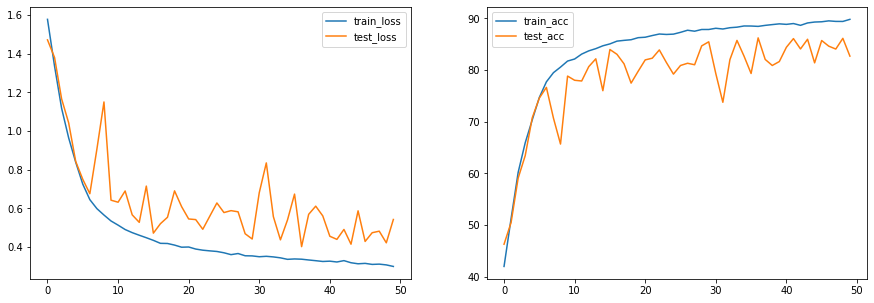

In [24]:
import matplotlib.pyplot as plt
losses = [item[0] for item in train_data]
tlosses = [item[0] for item in test_data]
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses, label='train_loss')
axs[0].plot(tlosses, label='test_loss')
fig.set_size_inches(15, 5)
axs[0].legend()

tacces = [item[1] for item in test_data]
acces = [item[1] for item in train_data]
axs[1].plot(acces, label='train_acc')
axs[1].plot(tacces, label='test_acc')
axs[1].legend()

plt.show()

# Resnet34

In [25]:
net = ResNet34()
net = net.to(device)
best_acc = 0

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [27]:
# Execute Training
train_data = []
test_data = []
for epoch in tnrange(50, desc='Training and Testing Epochs'):
    train_d = train(epoch)
    train_data.append(train_d)
    test_d = test_res(epoch, 'resnet34')
    test_data.append(test_d)
    scheduler.step()

Training and Testing Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

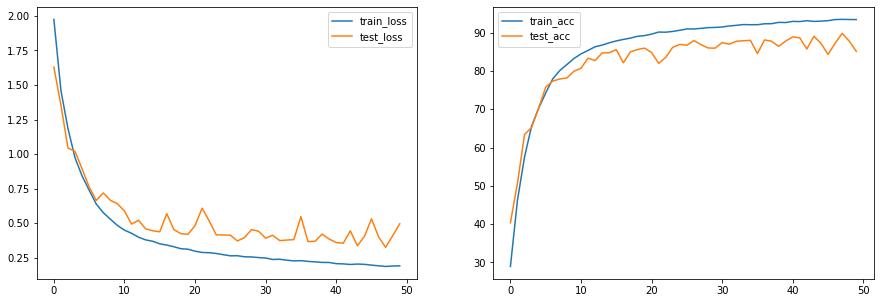

In [29]:
import matplotlib.pyplot as plt
losses = [item[0] for item in train_data]
tlosses = [item[0] for item in test_data]
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses, label='train_loss')
axs[0].plot(tlosses, label='test_loss')
fig.set_size_inches(15, 5)
axs[0].legend()

tacces = [item[1] for item in test_data]
acces = [item[1] for item in train_data]
axs[1].plot(acces, label='train_acc')
axs[1].plot(tacces, label='test_acc')
axs[1].legend()

plt.show()

# Resnet 50

In [ ]:
net = ResNet50()
net = net.to(device)
best_acc = 0
optimizer = optim.SGD(net.parameters(), lr=0.03,
                      momentum=0.9, weight_decay=5e-4)
for epoch in tnrange(40, desc='Training and Testing Epochs'):
    train_d = train(epoch)
    train_data.append(train_d)
    test_d = test_res(epoch, 'resnet50')
    test_data.append(test_d)
    scheduler.step()

Training and Testing Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving..


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

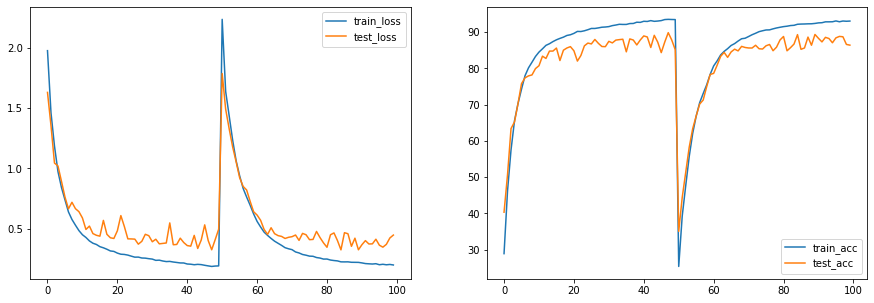

In [31]:
import matplotlib.pyplot as plt
losses = [item[0] for item in train_data]
tlosses = [item[0] for item in test_data]
fig, axs = plt.subplots(1, 2)
axs[0].plot(losses, label='train_loss')
axs[0].plot(tlosses, label='test_loss')
fig.set_size_inches(15, 5)
axs[0].legend()

tacces = [item[1] for item in test_data]
acces = [item[1] for item in train_data]
axs[1].plot(acces, label='train_acc')
axs[1].plot(tacces, label='test_acc')
axs[1].legend()

plt.show()

In [32]:
print(losses)

[1.9753155177816406, 1.4608087734798032, 1.1843150119342463, 0.9726715600094222, 0.8412437867325591, 0.7388872186393689, 0.638588184133515, 0.5760396314246575, 0.528571058493441, 0.4836043450990906, 0.44932493456946615, 0.42679975900198797, 0.3980686366558075, 0.37900961234289055, 0.36860311831659676, 0.35036860349233195, 0.3410375609117396, 0.3291131134533211, 0.31495168542160706, 0.3111652797826416, 0.29709349042924166, 0.28784404214843157, 0.2859787851038491, 0.28054977263635994, 0.271651377001077, 0.2634310257023253, 0.264028847236615, 0.25647122222368063, 0.25531064120628644, 0.2507967088571595, 0.24746575092187012, 0.23695634383603434, 0.23865084191950994, 0.2316132535981705, 0.22681988202168812, 0.22830329984045394, 0.22320985376758648, 0.219522056143607, 0.21554272231238578, 0.2152070540677556, 0.20674178600692383, 0.20497594575595368, 0.20069120501351478, 0.2038279787239516, 0.20168457774783644, 0.1960478576324175, 0.1911427850270515, 0.18648947931616508, 0.18976120600272017, 